<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-anya-23-ct/blob/main/5_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5. Quantization**


## 5.0 Setup Capabilities

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
/content/gdrive/MyDrive/ece5545/a2-anya-23-ct
M	3_training_and_analysis.ipynb
M	5_quantization.ipynb
Already on 'main'
Your branch is behind 'origin/main' by 4 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 1011.91 KiB | 1.40 MiB/s, done.
From https://github.com/ML-HW-SYS/a2-anya-23-ct
   18d0335..004e827  main       -> origin/main
Updating 3d08810..004e827
error: Your local changes to the following files would be overwritten by merge:
	3_training_and_analysis.ipynb
	5_quantization.ipynb
Please commit your changes or stash them before you merge.
Aborting
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Please verify the cell below prints out the github repository.

In [5]:
!ls '{PROJECT_ROOT}'

1_audio_preprocessing.ipynb	     5_quantization.ipynb	      README.md
2_size_estimator_and_profiler.ipynb  6_pruning.ipynb		      src
3_training_and_analysis.ipynb	     arduino_nano_33_ble_tutorial.md  tests
4_model_conversion.ipynb	     images


### Install required packages

In [6]:
# Install libraries
!pip install tqdm
!pip install torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00


### Import code dependencies

In [7]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy
import os

import sys

# Adding assignment 2 to the system path
# -- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = RANDOM_SEED
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 5.1 Define Quantization Functions

There are some test cases in the `tests` folder to verify basic functionality of your implemented functions--these will be run automatically every time you check in your code. Additionally, we've left some simple tests in this notebook as well for you to try things out.



#### TODO 0: Implement the backward pass of `ste_round` function in `src/quant.py`

In [8]:
# add a test if you like. There's already one under tests/


#### TODO 1: Implement the `linear_quantize` function in `src/quant.py`


In [9]:
from src.quant import linear_quantize

# Mini test case for linear_quantize
with torch.no_grad():
    x = torch.tensor([2, -0.5, 0., 1.])
    scale = 1
    zero = 0
    y = linear_quantize(x, scale, zero)
    print(y)

tensor([2., 0., 0., 1.])


#### TODO 2: Implement the `SymmetricQuantFunction` forward function in `src/quant.py`


In [10]:
from src.quant import SymmetricQuantFunction

quant_f = SymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)
print(x.grad)

tensor([1., -0., 0., 1.], grad_fn=<SymmetricQuantFunctionBackward>)
tensor([2., -0., 0., 2.])


#### TODO 3: Implement the `AsymmetricQuantFunction` forward function in `src/quant.py`

In [11]:
from src.quant import AsymmetricQuantFunction

quant_f = AsymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)
print(x.grad)

tensor([2., 0., 0., 1.], grad_fn=<AsymmetricQuantFunctionBackward>)
tensor([4., 0., 0., 2.])


#### TODO 4: Finish the Implement of `get_quantization_params` function in `src/quant.py`

In [12]:
from src.quant import QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)
print(qconfig.get_quantization_params(x.min(), x.max()))

qconfig = QConfig(quant_bits=4, is_symmetric=False)
print(qconfig.get_quantization_params(x.min(), x.max()))

(tensor(0.2857), tensor(0))
(tensor(0.1667), tensor(3.))


#### TODO 5: Implement the `quantize_weights_bias` function in `src/quant.py`

In [13]:
from src.quant import quantize_weights_bias, QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)

w1 = nn.Parameter(torch.tensor([2, -0.5, 0., 1.]))
qw1 = quantize_weights_bias(w1, qconfig)
print(qw1.data)

w2 = nn.Parameter(torch.tensor([2.5, -1, 0., 1.5]))
qw2 = quantize_weights_bias(w2, qconfig)
print(qw2.data)

tensor([ 7., -2.,  0.,  3.])
tensor([ 7., -3.,  0.,  4.])


## 5.2 Quantization Function for Linear and Convolution Layer

#### TODO 6: Finish the implementation of `conv2d_linear_quantized` function in `src/quant.py`

In [14]:
import torch.nn as nn
from src.quant import QuantWrapper

layer = nn.Linear(2, 2)
layer.weight.data = torch.tensor([[0.1, 0.1], [-0.1, 0.1]]).view(2, 2).float()
layer.bias.data = torch.tensor([1, 2]).view(*layer.bias.shape).float()
x = torch.tensor([[0., 1]])
print(layer(x))

quant_layer = QuantWrapper(
    layer,
    QConfig(quant_bits=4, is_symmetric=True),
    QConfig(quant_bits=4, is_symmetric=True),
    QConfig(quant_bits=4, is_symmetric=True))
print(quant_layer(x))


tensor([[1.1000, 2.1000]], grad_fn=<AddmmBackward0>)
tensor([[0.9571, 2.1000]], grad_fn=<AddmmBackward0>)


## 5.3 Prepare model for QAT (Quantization Aware Training)

### Get Audio Processor, Devices, Data Loader, and Model

NOTE: This is identical to section 2.2 .

In [15]:
# added based on Ed discussion tip
DATASET_DIR='/content/dataset'

In [16]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
# HINT: In case loading data takes too long, move the dataset from gdrive to /content/ and change the path accordingly.
audio_processor = data_proc.AudioProcessor(data_dir=DATASET_DIR)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

>> Downloading speech_commands_v0.02.tar.gz 100.0%
Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

### Load Pretrained Model for Quantization Aware Finetuning

In this notebook, we will load the previously trained 32-bits float model to finetune it in a quantizaiton-aware way.



In [17]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt			 quant_checkpoint_2bit.pt
 fp32_finetune_checkpoint.pt		 quant_checkpoint_2.pt
 pruned_unstructured_checkpoint_{t}.pt	 quant_checkpoint_6.pt
'(QAT2bit)quant_0.pt'			 quant_checkpoint_8.pt
'(QAT4bit)quant_0.pt'			 quant_checkpoint.pt
'(QAT6bit)quant_0.pt'			 tinyconv_float32_init_seed0_90.35%_0.pt
'(QAT8bit)quant_0.pt'


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [18]:
# TODO: Replace me!
# torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.35%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

### Define settings for weight and activation quantization

In [19]:
# We choose 4 bit quantization as an example because accuracy improvements will
# be more obvious with 4-bit or lower bit quantization
QUANT_BITS = 4
# Settings for activations quantization: n-bit asymmetric quantization
a_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=False)
# Settings for weights quantization: n-bit symmetric quantization
w_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)
# Settings for bias quantization: n-bit symmetric quantization
b_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)

### Prepare quantization aware training model

In [20]:
from src.quant import quantize_model
qat_model_nbit = quantize_model(
    model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)

# Print to see the model prepared for QAT
print(qat_model_nbit)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): QuantWrapper(
    (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): QuantWrapper(
    (module): Linear(in_features=4000, out_features=4, bias=True)
  	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=4, quant_m

##  5.4 Finetuning

In this training, we will finetune the 32-bits float pretrained model. The goal is to finetune the weights of the 32-bits float model such that the resulted model will have better accuracy after quantization.

### Quantization Aware Finetuning

In [21]:
# added based on Ed discussion tip
DATASET_DIR='/content/dataset'

In [22]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=qat_model_nbit, learning_rate=0.0001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint.pt")
qat_model_nbit.to(device)
run_training(
    model=qat_model_nbit, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_quant, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

#batches: 106 
#epochs: 30 
#total training steps: 3180
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 88.67%, Train loss = 0.381
Val Acc Epoch 2 = 89.57%, Train loss = 0.392
Val Acc Epoch 3 = 88.9%, Train loss = 0.394
Val Acc Epoch 4 = 88.82%, Train loss = 0.394
Val Acc Epoch 5 = 89.42%, Train loss = 0.387
Val Acc Epoch 6 = 88.9%, Train loss = 0.397
Val Acc Epoch 7 = 89.57%, Train loss = 0.386
Val Acc Epoch 8 = 89.27%, Train loss = 0.388
Val Acc Epoch 9 = 89.35%, Train loss = 0.385
Val Acc Epoch 10 = 88.9%, Train loss = 0.393
Val Acc Epoch 11 = 90.17%, Train loss = 0.392
Val Acc Epoch 12 = 89.2%, Train loss = 0.398
Val Acc Epoch 13 = 88.75%, Train loss = 0.397
Val Acc Epoch 14 = 89.05%, Train loss = 0.396
Val Acc Epoch 15 = 89.5%, Train loss = 0.402
Val Acc Epoch 16 = 88.6%, Train loss = 0.387
Val Acc Epoch 17 = 90.4%, Train loss = 0.397
Val Acc Epoch 18 = 89.57%, Train loss = 0.403
Val Acc Epoch 19 = 89.57%, Train loss = 0.394
Val Acc Epoch 20 = 89.8%, Train loss = 0.401
Val Acc Epoch 21 = 88.82%, Train loss = 0.393
Val Acc Epoch 22 = 89.95%, Train loss = 0.388
Val A

### Finetune the Float Model

For fair comparison, we conduct the same funetuning for the float model.

In [22]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer

def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

#batches: 106 
#epochs: 30 
#total training steps: 3180


In [26]:
# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.0001)

checkpoint_path = os.path.join(TORCH_DIR, "fp32_finetune_checkpoint_2.pt")
model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_fp32, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 88.15%, Train loss = 0.425
Val Acc Epoch 2 = 88.15%, Train loss = 0.405
Val Acc Epoch 3 = 88.0%, Train loss = 0.402
Val Acc Epoch 4 = 88.3%, Train loss = 0.405
Val Acc Epoch 5 = 87.85%, Train loss = 0.405
Val Acc Epoch 6 = 89.2%, Train loss = 0.4
Val Acc Epoch 7 = 89.12%, Train loss = 0.388
Val Acc Epoch 8 = 88.67%, Train loss = 0.397
Val Acc Epoch 9 = 88.82%, Train loss = 0.376
Val Acc Epoch 10 = 89.27%, Train loss = 0.381
Val Acc Epoch 11 = 89.05%, Train loss = 0.378
Val Acc Epoch 12 = 88.9%, Train loss = 0.377
Val Acc Epoch 13 = 89.35%, Train loss = 0.369
Val Acc Epoch 14 = 89.8%, Train loss = 0.365
Val Acc Epoch 15 = 89.72%, Train loss = 0.371
Val Acc Epoch 16 = 90.62%, Train loss = 0.365
Val Acc Epoch 17 = 89.27%, Train loss = 0.373
Val Acc Epoch 18 = 90.02%, Train loss = 0.364
Val Acc Epoch 19 = 90.1%, Train loss = 0.367
Val Acc Epoch 20 = 90.02%, Train loss = 0.366
Val Acc Epoch 21 = 90.1%, Train loss = 0.353
Val Acc Epoch 22 = 90.25%, Train loss = 0.359
Val Ac

## 5.5 Testing

We will compute the accuracy of the finetuned model in train/val/test set in this section.
Note that this is not the final accuracy we want the model to perform well on.
We would like our quantized-aware-finetuned model to perform well when quantized into integer.
But the training/validation/testing accuracy of these model in quantization simulation model is still worth looking at for sanity checking purpose.

Train size: 10556 Val size: 1333 Test size: 1368


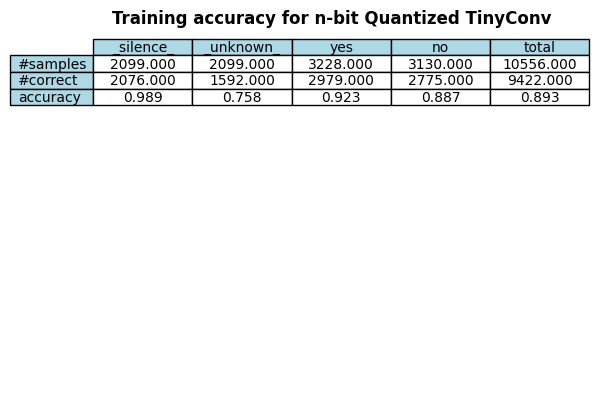

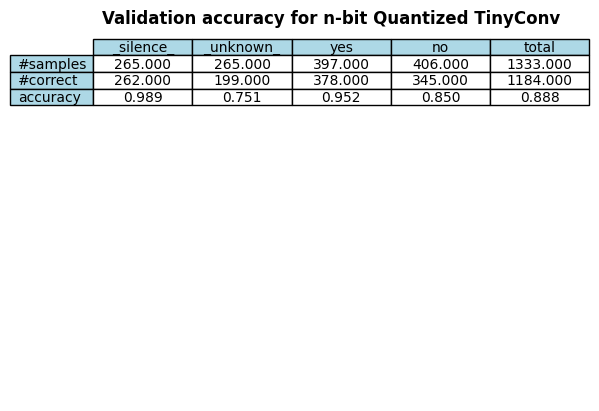

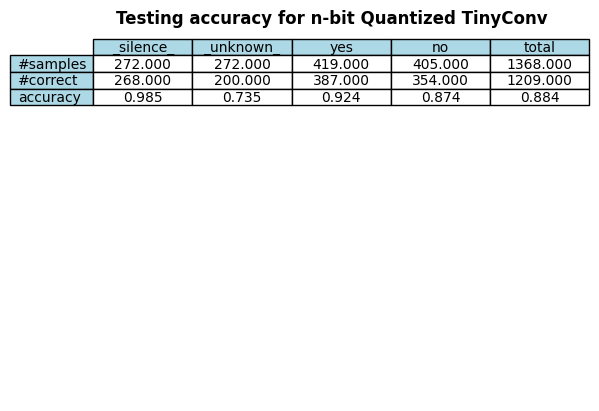

0.8837719298245614

In [24]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device,
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['training'], qat_model_nbit, audio_processor, device,
    "Training", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], qat_model_nbit, audio_processor, device,
    "Validation", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['testing'], qat_model_nbit, audio_processor, device,
    'Testing', 'n-bit Quantized TinyConv', "float")

## 5.6 Saving the Trained Model

In [25]:
from src.train_val_test_utils import choose_name
from src.quant import dequantize_model

# Save the qat model
qat_model_nbit_float = dequantize_model(qat_model_nbit)
file_name = choose_name("quant")
# You can also define your own path
qat_torch_path = os.path.join(TORCH_DIR, f'(QAT{QUANT_BITS}bit){file_name}.pt')
# Save the trained n-bit qat pytorch model to PATH
torch.save(qat_model_nbit.state_dict(), qat_torch_path)
qat_torch_path

Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
The model's will be stored as: 
 quant_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/(QAT4bit)quant_0.pt'

## 5.7 Understanding and Evaluate the Effectiveness of Quantization-Aware Training (QAT)

### Model conversion: Quantized/Float Fine-tuning Model Converted to Integer Models

In [26]:
from src.quant import dequantize_model
from src.quant_conversion import convert_to_int

In [27]:
# Convert to quantized model

# Quantized integer model of qat_model_nbit (quantized aware finetuning model)
int_model_nbit = convert_to_int(
    qat_model_nbit, QUANT_BITS, dtype=torch.int32)

# Post quantized model of model_fp32 (full-precision finetuned model)
post_quant_model = convert_to_int(
    model_fp32, QUANT_BITS, dtype=torch.int32)

# Floating point models of the qat_model_nbit, without QuantWrappers
float_model_nbit = dequantize_model(qat_model_nbit)

print(int_model_nbit)

Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
Sequential(
  (quant): Quant(): qconfig=quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None ; dtype=torch.int32
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv_quant): Quant(): qconfig=quant_bits=4, quant_mode=asymmetric, prev_scale=1.7005208730697632, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.5078125 ; dtype=torch.int32
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): R

In [28]:
from src.quant_conversion import print_features

# Select a sample data to see the features of it
sample_data, _ = audio_processor.get_data_from_file(
    audio_processor.data_index['testing'][0], BACKGROUND_FREQUENCY,
    BACKGROUND_VOLUME_RANGE, TIME_SHIFT_SAMPLE, 'testing')

print("=" * 80)
print("Features from Quantized QAT Model")
print("-" * 80)
print_features(sample_data, int_model_nbit, 'Quantized QAT Model')
print()
print("=" * 80)
print("Features from Model fp32")
print("-" * 80)
print_features(sample_data, model_fp32, "Model fp32")

Features from Quantized QAT Model
--------------------------------------------------------------------------------
features of Quantized QAT Model parameters:
conv.weight: min=-7; max=4; dtype=torch.int32; shape=torch.Size([8, 1, 10, 8])
conv.bias: min=-23; max=3; dtype=torch.int32; shape=torch.Size([8])
fc.weight: min=-7; max=7; dtype=torch.int32; shape=torch.Size([4, 4000])
fc.bias: min=-11; max=20; dtype=torch.int32; shape=torch.Size([4])
features of Quantized QAT Model activations/outputs
input: min=0.0; max=25.6640625; dtype=torch.float32; shape=torch.Size([1, 1960])
output of quant: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1960])
output of conv_reshape: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv_quant: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv: min=-1293; max=114; dtype=torch.int32; shape=torch.Size([1, 8, 25, 20])
output of relu: min=0; max=114; dtype=torch.int32; shape=torch.Size([1, 8,

### Compare the Performance Between Integer Models from Float/Quantized-Aware Finetuning

In [29]:
from src.quant_conversion import compare_model, compare_model_mse

# Compare differences in predictions
# QAT trained floating point model vs. integer model converted from the QAT model
# Percentage of same predictions shows how "quantization aware" the float point model is
_ = compare_model(test_loader, float_model_nbit, int_model_nbit)
_ = compare_model_mse(test_loader, float_model_nbit, int_model_nbit)

The models have 98.538% same predictions, 
Model1 predicts 89.620% of the samples correctly, 
Model2 predicts 89.401% of the samples correctly
MSE between two models' prediction: 0.0115


In [30]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model)

The models have 95.249% same predictions, 
Model1 predicts 90.643% of the samples correctly, 
Model2 predicts 89.035% of the samples correctly
MSE between two models' prediction: 0.0192


6-bit

In [37]:
# TODO: Replace me!
# torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.35%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [38]:
# We choose 4 bit quantization as an example because accuracy improvements will
# be more obvious with 4-bit or lower bit quantization
QUANT_BITS = 6
# Settings for activations quantization: n-bit asymmetric quantization
a_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=False)
# Settings for weights quantization: n-bit symmetric quantization
w_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)
# Settings for bias quantization: n-bit symmetric quantization
b_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)

In [39]:
from src.quant import quantize_model
qat_model_6bit = quantize_model(
    model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)

# Print to see the model prepared for QAT
print(qat_model_6bit)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): QuantWrapper(
    (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  	(activation): quant_bits=6, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=6, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=6, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): QuantWrapper(
    (module): Linear(in_features=4000, out_features=4, bias=True)
  	(activation): quant_bits=6, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=6, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=6, quant_m

In [40]:
# added based on Ed discussion tip
DATASET_DIR='/content/dataset'

In [41]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
# HINT: In case loading data takes too long, move the dataset from gdrive to /content/ and change the path accordingly.
audio_processor = data_proc.AudioProcessor(data_dir=DATASET_DIR)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [42]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=qat_model_6bit, learning_rate=0.0001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint_6.pt")
qat_model_6bit.to(device)
run_training(
    model=qat_model_6bit, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_quant, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

#batches: 106 
#epochs: 30 
#total training steps: 3180
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 89.5%, Train loss = 0.35
Val Acc Epoch 2 = 90.17%, Train loss = 0.346
Val Acc Epoch 3 = 90.47%, Train loss = 0.337
Val Acc Epoch 4 = 90.32%, Train loss = 0.347
Val Acc Epoch 5 = 90.1%, Train loss = 0.336
Val Acc Epoch 6 = 90.25%, Train loss = 0.334
Val Acc Epoch 7 = 89.8%, Train loss = 0.349
Val Acc Epoch 8 = 90.02%, Train loss = 0.352
Val Acc Epoch 9 = 89.72%, Train loss = 0.344
Val Acc Epoch 10 = 90.32%, Train loss = 0.342
Val Acc Epoch 11 = 89.8%, Train loss = 0.347
Val Acc Epoch 12 = 90.4%, Train loss = 0.342
Val Acc Epoch 13 = 89.95%, Train loss = 0.355
Val Acc Epoch 14 = 90.1%, Train loss = 0.348
Val Acc Epoch 15 = 90.4%, Train loss = 0.346
Val Acc Epoch 16 = 90.17%, Train loss = 0.343
Val Acc Epoch 17 = 91.45%, Train loss = 0.349
Val Acc Epoch 18 = 89.95%, Train loss = 0.349
Val Acc Epoch 19 = 90.55%, Train loss = 0.34
Val Acc Epoch 20 = 89.57%, Train loss = 0.342
Val Acc Epoch 21 = 89.72%, Train loss = 0.345
Val Acc Epoch 22 = 90.92%, Train loss = 0.349
Val Ac

Train size: 10556 Val size: 1333 Test size: 1368


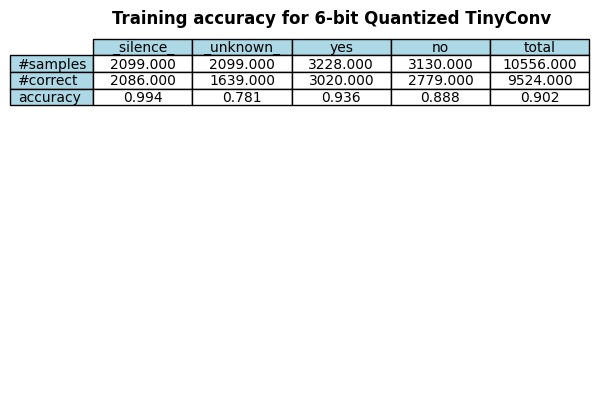

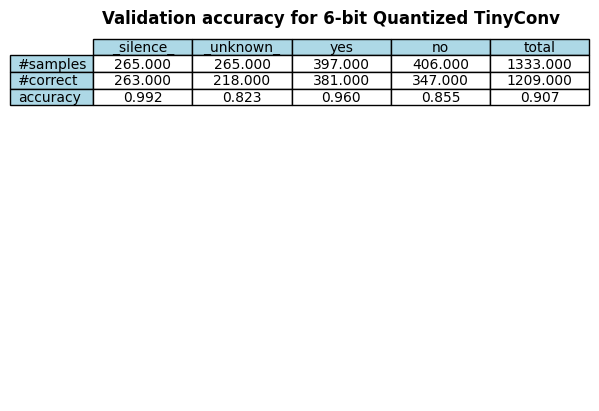

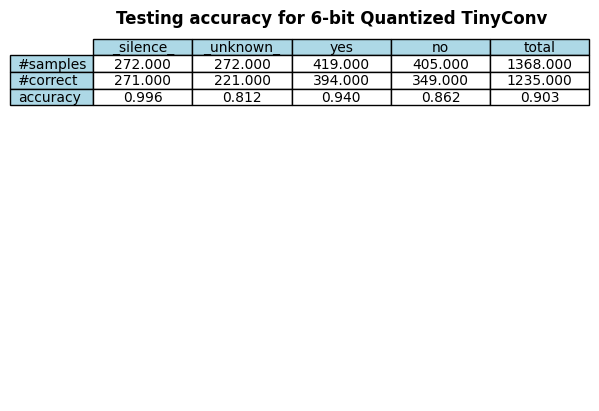

0.9027777777777778

In [43]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device,
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['training'], qat_model_6bit, audio_processor, device,
    "Training", '6-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], qat_model_6bit, audio_processor, device,
    "Validation", '6-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['testing'], qat_model_6bit, audio_processor, device,
    'Testing', '6-bit Quantized TinyConv', "float")

In [44]:
from src.train_val_test_utils import choose_name
from src.quant import dequantize_model

# Save the qat model
qat_model_6bit_float = dequantize_model(qat_model_6bit)
file_name = choose_name("quant")
# You can also define your own path
qat_torch_path = os.path.join(TORCH_DIR, f'(QAT{QUANT_BITS}bit){file_name}.pt')
# Save the trained n-bit qat pytorch model to PATH
torch.save(qat_model_6bit.state_dict(), qat_torch_path)
qat_torch_path

Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
The model's will be stored as: 
 quant_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/(QAT6bit)quant_0.pt'

In [45]:
from src.quant import dequantize_model
from src.quant_conversion import convert_to_int

In [46]:
# Convert to quantized model

# Quantized integer model of qat_model_nbit (quantized aware finetuning model)
int_model_6bit = convert_to_int(
    qat_model_6bit, QUANT_BITS, dtype=torch.int32)

# Post quantized model of model_fp32 (full-precision finetuned model)
post_quant_model = convert_to_int(
    model_fp32, QUANT_BITS, dtype=torch.int32)

# Floating point models of the qat_model_nbit, without QuantWrappers
float_model_6bit = dequantize_model(qat_model_6bit)

print(int_model_6bit)

Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
Sequential(
  (quant): Quant(): qconfig=quant_bits=6, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None ; dtype=torch.int32
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv_quant): Quant(): qconfig=quant_bits=6, quant_mode=asymmetric, prev_scale=0.4048859477043152, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.5078125 ; dtype=torch.int32
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): R

In [47]:
from src.quant_conversion import print_features

# Select a sample data to see the features of it
sample_data, _ = audio_processor.get_data_from_file(
    audio_processor.data_index['testing'][0], BACKGROUND_FREQUENCY,
    BACKGROUND_VOLUME_RANGE, TIME_SHIFT_SAMPLE, 'testing')

print("=" * 80)
print("Features from Quantized QAT Model")
print("-" * 80)
print_features(sample_data, int_model_6bit, 'Quantized QAT Model')
print()
print("=" * 80)
print("Features from Model fp32")
print("-" * 80)
print_features(sample_data, model_fp32, "Model fp32")

Features from Quantized QAT Model
--------------------------------------------------------------------------------
features of Quantized QAT Model parameters:
conv.weight: min=-31; max=16; dtype=torch.int32; shape=torch.Size([8, 1, 10, 8])
conv.bias: min=-353; max=68; dtype=torch.int32; shape=torch.Size([8])
fc.weight: min=-30; max=31; dtype=torch.int32; shape=torch.Size([4, 4000])
fc.bias: min=-320; max=583; dtype=torch.int32; shape=torch.Size([4])
features of Quantized QAT Model activations/outputs
input: min=0.0; max=25.703125; dtype=torch.float32; shape=torch.Size([1, 1960])
output of quant: min=0; max=63; dtype=torch.int32; shape=torch.Size([1, 1960])
output of conv_reshape: min=0; max=63; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv_quant: min=0; max=63; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv: min=-23985; max=1920; dtype=torch.int32; shape=torch.Size([1, 8, 25, 20])
output of relu: min=0; max=1920; dtype=torch.int32; shape=torch.S

In [48]:
from src.quant_conversion import compare_model, compare_model_mse

# Compare differences in predictions
# QAT trained floating point model vs. integer model converted from the QAT model
# Percentage of same predictions shows how "quantization aware" the float point model is
_ = compare_model(test_loader, float_model_6bit, int_model_6bit)
_ = compare_model_mse(test_loader, float_model_6bit, int_model_6bit)

The models have 99.488% same predictions, 
Model1 predicts 89.401% of the samples correctly, 
Model2 predicts 89.693% of the samples correctly
MSE between two models' prediction: 0.0127


2-bit

In [56]:
# TODO: Replace me!
# torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.35%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [57]:
# We choose 4 bit quantization as an example because accuracy improvements will
# be more obvious with 4-bit or lower bit quantization
QUANT_BITS = 2
# Settings for activations quantization: n-bit asymmetric quantization
a_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=False)
# Settings for weights quantization: n-bit symmetric quantization
w_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)
# Settings for bias quantization: n-bit symmetric quantization
b_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)

In [58]:
from src.quant import quantize_model
qat_model_2bit = quantize_model(
    model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)

# Print to see the model prepared for QAT
print(qat_model_2bit)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): QuantWrapper(
    (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  	(activation): quant_bits=2, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=2, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=2, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): QuantWrapper(
    (module): Linear(in_features=4000, out_features=4, bias=True)
  	(activation): quant_bits=2, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=2, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=2, quant_m

In [59]:
# added based on Ed discussion tip
DATASET_DIR='/content/dataset'

In [60]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
# HINT: In case loading data takes too long, move the dataset from gdrive to /content/ and change the path accordingly.
audio_processor = data_proc.AudioProcessor(data_dir=DATASET_DIR)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [61]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=qat_model_2bit, learning_rate=0.0005)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint_2.pt")
qat_model_2bit.to(device)
run_training(
    model=qat_model_2bit, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_quant, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

#batches: 106 
#epochs: 30 
#total training steps: 3180
{'state': {}, 'param_groups': [{'lr': 0.0005, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 19.88%, Train loss = 1.424
Val Acc Epoch 2 = 19.88%, Train loss = 1.418
Val Acc Epoch 3 = 19.88%, Train loss = 1.413
Val Acc Epoch 4 = 19.88%, Train loss = 1.41
Val Acc Epoch 5 = 19.88%, Train loss = 1.407
Val Acc Epoch 6 = 19.88%, Train loss = 1.405
Val Acc Epoch 7 = 19.88%, Train loss = 1.403
Val Acc Epoch 8 = 19.88%, Train loss = 1.402
Val Acc Epoch 9 = 19.88%, Train loss = 1.401
Val Acc Epoch 10 = 19.88%, Train loss = 1.4
Val Acc Epoch 11 = 19.88%, Train loss = 1.4
Val Acc Epoch 12 = 19.88%, Train loss = 1.399
Val Acc Epoch 13 = 19.88%, Train loss = 1.399
Val Acc Epoch 14 = 19.88%, Train loss = 1.399
Val Acc Epoch 15 = 19.88%, Train loss = 1.399
Val Acc Epoch 16 = 19.88%, Train loss = 1.398
Val Acc Epoch 17 = 19.88%, Train loss = 1.398
Val Acc Epoch 18 = 19.88%, Train loss = 1.398
Val Acc Epoch 19 = 19.88%, Train loss = 1.398
Val Acc Epoch 20 = 19.88%, Train loss = 1.399
Val Acc Epoch 21 = 19.88%, Train loss = 1.398
Val Acc Epoch 22 = 19.88%, Train loss = 1.398
Va

Train size: 10556 Val size: 1333 Test size: 1368


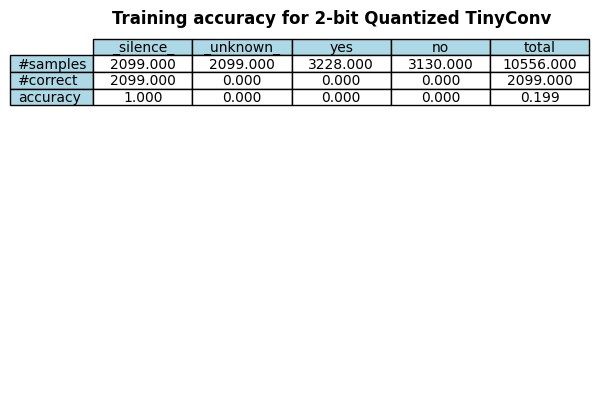

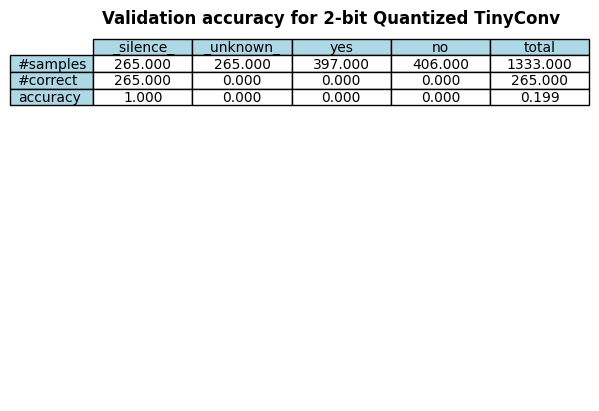

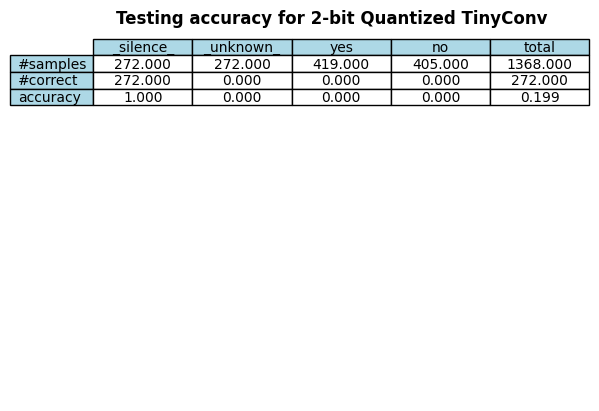

0.19883040935672514

In [62]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device,
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['training'], qat_model_2bit, audio_processor, device,
    "Training", '2-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], qat_model_2bit, audio_processor, device,
    "Validation", '2-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['testing'], qat_model_2bit, audio_processor, device,
    'Testing', '2-bit Quantized TinyConv', "float")

In [63]:
from src.train_val_test_utils import choose_name
from src.quant import dequantize_model

# Save the qat model
qat_model_2bit_float = dequantize_model(qat_model_2bit)
file_name = choose_name("quant")
# You can also define your own path
qat_torch_path = os.path.join(TORCH_DIR, f'(QAT{QUANT_BITS}bit){file_name}.pt')
# Save the trained n-bit qat pytorch model to PATH
torch.save(qat_model_2bit.state_dict(), qat_torch_path)
qat_torch_path

Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
The model's will be stored as: 
 quant_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/(QAT2bit)quant_0.pt'

In [64]:
from src.quant import dequantize_model
from src.quant_conversion import convert_to_int

In [65]:
# Convert to quantized model

# Quantized integer model of qat_model_nbit (quantized aware finetuning model)
int_model_2bit = convert_to_int(
    qat_model_2bit, QUANT_BITS, dtype=torch.int32)

# Post quantized model of model_fp32 (full-precision finetuned model)
post_quant_model = convert_to_int(
    model_fp32, QUANT_BITS, dtype=torch.int32)

# Floating point models of the qat_model_nbit, without QuantWrappers
float_model_2bit = dequantize_model(qat_model_2bit)

print(int_model_2bit)

Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
Sequential(
  (quant): Quant(): qconfig=quant_bits=2, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None ; dtype=torch.int32
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv_quant): Quant(): qconfig=quant_bits=2, quant_mode=asymmetric, prev_scale=8.489583969116211, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.46875 ; dtype=torch.int32
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU

In [66]:
from src.quant_conversion import print_features

# Select a sample data to see the features of it
sample_data, _ = audio_processor.get_data_from_file(
    audio_processor.data_index['testing'][0], BACKGROUND_FREQUENCY,
    BACKGROUND_VOLUME_RANGE, TIME_SHIFT_SAMPLE, 'testing')

print("=" * 80)
print("Features from Quantized QAT Model")
print("-" * 80)
print_features(sample_data, int_model_2bit, 'Quantized QAT Model')
print()
print("=" * 80)
print("Features from Model fp32")
print("-" * 80)
print_features(sample_data, model_fp32, "Model fp32")

Features from Quantized QAT Model
--------------------------------------------------------------------------------
features of Quantized QAT Model parameters:
conv.weight: min=-1; max=1; dtype=torch.int32; shape=torch.Size([8, 1, 10, 8])
conv.bias: min=-2147483648; max=0; dtype=torch.int32; shape=torch.Size([8])
fc.weight: min=-1; max=1; dtype=torch.int32; shape=torch.Size([4, 4000])
fc.bias: min=-2147483648; max=2147483647; dtype=torch.int32; shape=torch.Size([4])
features of Quantized QAT Model activations/outputs
input: min=0.0; max=25.859375; dtype=torch.float32; shape=torch.Size([1, 1960])
output of quant: min=0; max=3; dtype=torch.int32; shape=torch.Size([1, 1960])
output of conv_reshape: min=0; max=3; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv_quant: min=0; max=3; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv: min=-2147483648; max=2147483647; dtype=torch.int32; shape=torch.Size([1, 8, 25, 20])
output of relu: min=0; max=2147483647; dt

In [67]:
from src.quant_conversion import compare_model, compare_model_mse

# Compare differences in predictions
# QAT trained floating point model vs. integer model converted from the QAT model
# Percentage of same predictions shows how "quantization aware" the float point model is
_ = compare_model(test_loader, float_model_2bit, int_model_2bit)
_ = compare_model_mse(test_loader, float_model_2bit, int_model_2bit)

The models have 100.000% same predictions, 
Model1 predicts 19.883% of the samples correctly, 
Model2 predicts 19.883% of the samples correctly
MSE between two models' prediction: 0.1605


8-bit

In [75]:
# TODO: Replace me!
# torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.35%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [76]:
# We choose 4 bit quantization as an example because accuracy improvements will
# be more obvious with 4-bit or lower bit quantization
QUANT_BITS = 8
# Settings for activations quantization: n-bit asymmetric quantization
a_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=False)
# Settings for weights quantization: n-bit symmetric quantization
w_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)
# Settings for bias quantization: n-bit symmetric quantization
b_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)

In [77]:
from src.quant import quantize_model
qat_model_8bit = quantize_model(
    model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)

# Print to see the model prepared for QAT
print(qat_model_8bit)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): QuantWrapper(
    (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  	(activation): quant_bits=8, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=8, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=8, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): QuantWrapper(
    (module): Linear(in_features=4000, out_features=4, bias=True)
  	(activation): quant_bits=8, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=8, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=8, quant_m

In [78]:
# added based on Ed discussion tip
DATASET_DIR='/content/dataset'

In [79]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
# HINT: In case loading data takes too long, move the dataset from gdrive to /content/ and change the path accordingly.
audio_processor = data_proc.AudioProcessor(data_dir=DATASET_DIR)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [80]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=qat_model_8bit, learning_rate=0.0001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint_8.pt")
qat_model_8bit.to(device)
run_training(
    model=qat_model_8bit, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_quant, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

#batches: 106 
#epochs: 30 
#total training steps: 3180
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 89.57%, Train loss = 0.35
Val Acc Epoch 2 = 90.32%, Train loss = 0.347
Val Acc Epoch 3 = 90.62%, Train loss = 0.358
Val Acc Epoch 4 = 89.8%, Train loss = 0.349
Val Acc Epoch 5 = 90.47%, Train loss = 0.348
Val Acc Epoch 6 = 90.32%, Train loss = 0.355
Val Acc Epoch 7 = 89.65%, Train loss = 0.348
Val Acc Epoch 8 = 90.02%, Train loss = 0.351
Val Acc Epoch 9 = 90.25%, Train loss = 0.344
Val Acc Epoch 10 = 90.32%, Train loss = 0.338
Val Acc Epoch 11 = 90.62%, Train loss = 0.344
Val Acc Epoch 12 = 89.8%, Train loss = 0.338
Val Acc Epoch 13 = 90.1%, Train loss = 0.336
Val Acc Epoch 14 = 90.62%, Train loss = 0.349
Val Acc Epoch 15 = 90.7%, Train loss = 0.349
Val Acc Epoch 16 = 89.8%, Train loss = 0.349
Val Acc Epoch 17 = 90.55%, Train loss = 0.347
Val Acc Epoch 18 = 90.25%, Train loss = 0.344
Val Acc Epoch 19 = 89.57%, Train loss = 0.342
Val Acc Epoch 20 = 90.17%, Train loss = 0.344
Val Acc Epoch 21 = 89.8%, Train loss = 0.342
Val Acc Epoch 22 = 89.12%, Train loss = 0.341
Val 

Train size: 10556 Val size: 1333 Test size: 1368


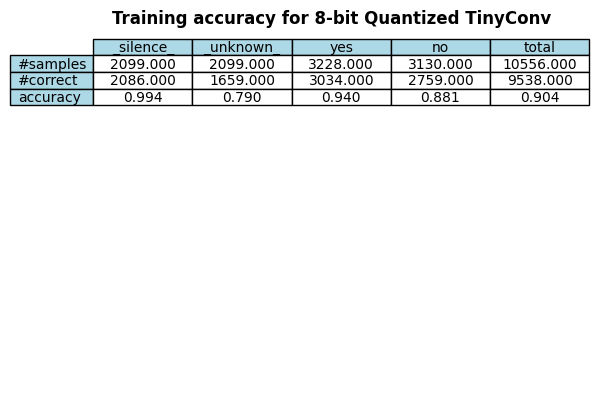

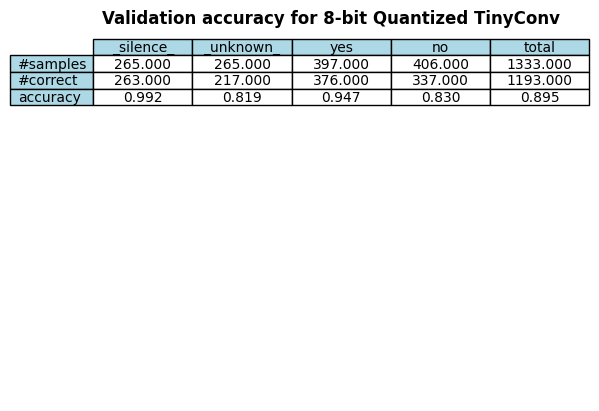

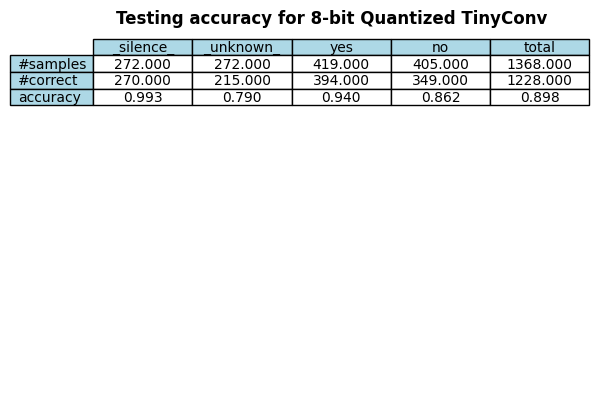

0.8976608187134503

In [81]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device,
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['training'], qat_model_8bit, audio_processor, device,
    "Training", '8-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], qat_model_8bit, audio_processor, device,
    "Validation", '8-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['testing'], qat_model_8bit, audio_processor, device,
    'Testing', '8-bit Quantized TinyConv', "float")

In [83]:
from src.train_val_test_utils import choose_name
from src.quant import dequantize_model

# Save the qat model
qat_model_8bit_float = dequantize_model(qat_model_8bit)
file_name = choose_name("quant")
# You can also define your own path
qat_torch_path = os.path.join(TORCH_DIR, f'(QAT{QUANT_BITS}bit){file_name}.pt')
# Save the trained n-bit qat pytorch model to PATH
torch.save(qat_model_8bit.state_dict(), qat_torch_path)
qat_torch_path

Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
The model's will be stored as: 
 quant_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/(QAT8bit)quant_0.pt'

In [28]:
from src.quant import dequantize_model
from src.quant_conversion import convert_to_int

In [85]:
# Convert to quantized model

# Quantized integer model of qat_model_nbit (quantized aware finetuning model)
int_model_8bit = convert_to_int(
    qat_model_8bit, QUANT_BITS, dtype=torch.int32)

# Post quantized model of model_fp32 (full-precision finetuned model)
post_quant_model = convert_to_int(
    model_fp32, QUANT_BITS, dtype=torch.int32)

# Floating point models of the qat_model_nbit, without QuantWrappers
float_model_8bit = dequantize_model(qat_model_8bit)

print(int_model_8bit)

Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
Sequential(
  (quant): Quant(): qconfig=quant_bits=8, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None ; dtype=torch.int32
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv_quant): Quant(): qconfig=quant_bits=8, quant_mode=asymmetric, prev_scale=0.10003064572811127, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.5078125 ; dtype=torch.int32
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): 

In [86]:
from src.quant_conversion import print_features

# Select a sample data to see the features of it
sample_data, _ = audio_processor.get_data_from_file(
    audio_processor.data_index['testing'][0], BACKGROUND_FREQUENCY,
    BACKGROUND_VOLUME_RANGE, TIME_SHIFT_SAMPLE, 'testing')

print("=" * 80)
print("Features from Quantized QAT Model")
print("-" * 80)
print_features(sample_data, int_model_8bit, 'Quantized QAT Model')
print()
print("=" * 80)
print("Features from Model fp32")
print("-" * 80)
print_features(sample_data, model_fp32, "Model fp32")

Features from Quantized QAT Model
--------------------------------------------------------------------------------
features of Quantized QAT Model parameters:
conv.weight: min=-127; max=66; dtype=torch.int32; shape=torch.Size([8, 1, 10, 8])
conv.bias: min=-6307; max=1241; dtype=torch.int32; shape=torch.Size([8])
fc.weight: min=-124; max=127; dtype=torch.int32; shape=torch.Size([4, 4000])
fc.bias: min=-6126; max=11442; dtype=torch.int32; shape=torch.Size([4])
features of Quantized QAT Model activations/outputs
input: min=0.0; max=25.78125; dtype=torch.float32; shape=torch.Size([1, 1960])
output of quant: min=0; max=255; dtype=torch.int32; shape=torch.Size([1, 1960])
output of conv_reshape: min=0; max=255; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv_quant: min=0; max=255; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv: min=-403684; max=37249; dtype=torch.int32; shape=torch.Size([1, 8, 25, 20])
output of relu: min=0; max=37249; dtype=torch.int32;

In [87]:
from src.quant_conversion import compare_model, compare_model_mse

# Compare differences in predictions
# QAT trained floating point model vs. integer model converted from the QAT model
# Percentage of same predictions shows how "quantization aware" the float point model is
_ = compare_model(test_loader, float_model_8bit, int_model_8bit)
_ = compare_model_mse(test_loader, float_model_8bit, int_model_8bit)

The models have 99.854% same predictions, 
Model1 predicts 89.620% of the samples correctly, 
Model2 predicts 89.474% of the samples correctly
MSE between two models' prediction: 0.0137


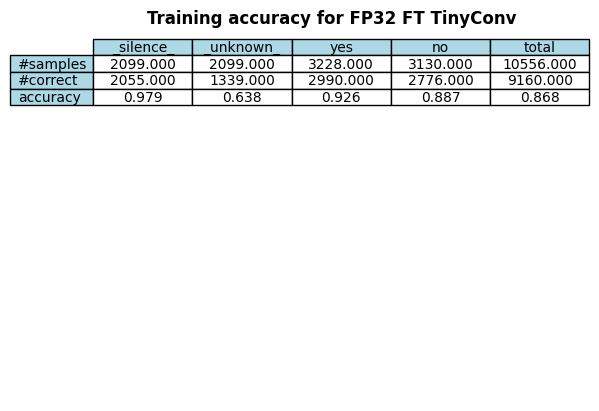

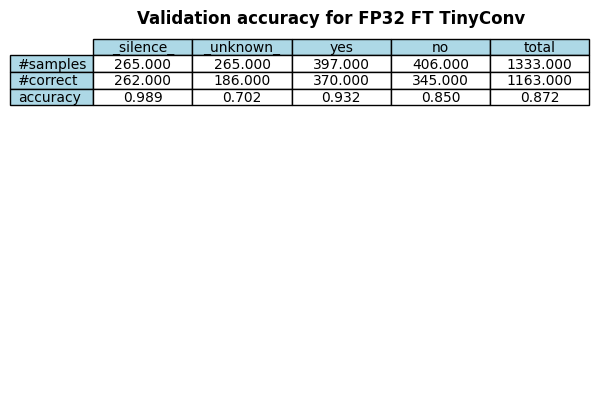

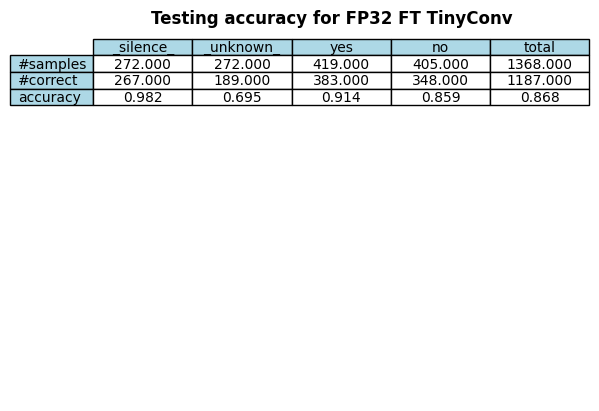

In [95]:
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "Training", 'FP32 FT TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "Validation", 'FP32 FT TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'Testing', 'FP32 FT TinyConv', "float")

In [29]:
post_quant_model_8 = convert_to_int(
    model_fp32, 8, dtype=torch.int32)

post_quant_model_6 = convert_to_int(
    model_fp32, 6, dtype=torch.int32)

post_quant_model_4 = convert_to_int(
    model_fp32, 4, dtype=torch.int32)

post_quant_model_2 = convert_to_int(
    model_fp32, 2, dtype=torch.int32)

Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))


In [30]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model_8)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model_8)

The models have 98.465% same predictions, 
Model1 predicts 88.670% of the samples correctly, 
Model2 predicts 88.743% of the samples correctly
MSE between two models' prediction: 0.0133


In [31]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model_6)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model_6)

The models have 98.319% same predictions, 
Model1 predicts 90.278% of the samples correctly, 
Model2 predicts 89.693% of the samples correctly
MSE between two models' prediction: 0.0142


In [32]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model_4)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model_4)

The models have 92.763% same predictions, 
Model1 predicts 89.693% of the samples correctly, 
Model2 predicts 88.158% of the samples correctly
MSE between two models' prediction: 0.0234


In [33]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model_2)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model_2)

The models have 30.482% same predictions, 
Model1 predicts 88.962% of the samples correctly, 
Model2 predicts 30.994% of the samples correctly
MSE between two models' prediction: 0.2534
